In [1]:
# Download the dataset in jupyter notebook
!git clone https://github.com/Shenggan/BCCD_Dataset.git

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.


In [2]:
# Change directory to the dataset
import os
os.chdir("BCCD_Dataset")

In [3]:
# List the dataset files to verify
import os

# List the files and folders
print(os.listdir("."))

['plot.py', 'LICENSE', 'dataset', 'test.csv', 'export.py', 'BCCD_Dataset', 'labels_one_hot.csv', 'README.md', '.gitignore', 'scripts', 'BCCD', 'resnet50_bccd.pth', '.git', 'example.jpg']


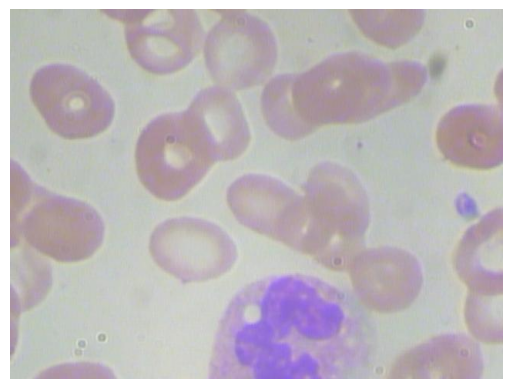

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to images folder
img_folder = "BCCD/JPEGImages"

# List all image files
img_files = os.listdir(img_folder)

# Display the first image
img_path = os.path.join(img_folder, img_files[0])
img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

In [5]:
# Install required libraries
!pip install torch torchvision numpy opencv-python matplotlib tqdm

In [6]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.optim as optim

In [7]:
# # Clone the dataset
# !git clone https://github.com/Shenggan/BCCD_Dataset.git

# # Change directory
# os.chdir("BCCD_Dataset")

# # Verify files
# print(os.listdir("BCCD"))

In [8]:
import os
import xml.etree.ElementTree as ET

def extract_labels(annotation_folder):
    labels = {}  # Dictionary to store labels for each image
    
    for xml_file in os.listdir(annotation_folder):
        if xml_file.endswith(".xml"):
            tree = ET.parse(os.path.join(annotation_folder, xml_file))
            root = tree.getroot()
            
            image_name = root.find("filename").text  # Get the image filename
            objects = root.findall("object")
            
            image_labels = []  # Store labels for this image
            for obj in objects:
                class_label = obj.find("name").text  # Extract class name
                image_labels.append(class_label)
            
            labels[image_name] = image_labels  # Store labels for this image
    
    return labels

# Example usage
annotation_path = "BCCD/Annotations"  # Update path if necessary
labels_dict = extract_labels(annotation_path)

# Print the labels for each image
for img, lbls in labels_dict.items():
    print(f"{img}: {lbls}")

BloodImage_00315.jpg: ['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'WBC', 'Platelets']
BloodImage_00301.jpg: ['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'WBC', 'Platelets']
BloodImage_00117.jpg: ['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'Platelets', 'Platelets', 'WBC', 'RBC', 'RBC']
BloodImage_00103.jpg: ['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'WBC', 'Platelets']
BloodImage_00088.jpg: ['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'WBC', 'Platelets', 'Platelets']
BloodImage_00063.jpg: ['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'WBC']
BloodImage_00077.jpg: ['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'WBC', 'Platelets', 'Platelets']
BloodImage_00261.jpg: ['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'Platelets', 'WBC']
BloodImage_00275.jpg: ['RBC', 'RBC', 'RBC'

In [9]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

# Define class labels and their one-hot indices
CLASS_MAP = {'RBC': 0, 'WBC': 1, 'Platelets': 2}

def extract_one_hot_labels(annotation_folder):
    labels_dict = {}

    for xml_file in os.listdir(annotation_folder):
        if xml_file.endswith(".xml"):
            tree = ET.parse(os.path.join(annotation_folder, xml_file))
            root = tree.getroot()
            
            image_name = root.find("filename").text  # Get the image filename
            
            # Create a one-hot vector for the labels
            one_hot_vector = np.zeros(len(CLASS_MAP), dtype=int)
            
            for obj in root.findall("object"):
                class_label = obj.find("name").text
                if class_label in CLASS_MAP:
                    one_hot_vector[CLASS_MAP[class_label]] = 1  # Set corresponding index to 1
            
            labels_dict[image_name] = one_hot_vector.tolist()  # Convert to list for easier saving

    return labels_dict

# Example usage
annotation_path = "BCCD/Annotations"  
one_hot_labels = extract_one_hot_labels(annotation_path)

# Convert to Pandas DataFrame for easier visualization
df = pd.DataFrame.from_dict(one_hot_labels, orient="index", columns=["RBC", "WBC", "Platelets"])
print(df.head())  # Display first few rows

# Save to CSV for future use
df.to_csv("labels_one_hot.csv", index=True, index_label="Image")

                      RBC  WBC  Platelets
BloodImage_00315.jpg    1    1          1
BloodImage_00301.jpg    1    1          1
BloodImage_00117.jpg    1    1          1
BloodImage_00103.jpg    1    1          1
BloodImage_00088.jpg    1    1          1


In [10]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define image folder and label file paths
IMAGE_FOLDER = "BCCD/JPEGImages"
LABEL_FILE = "labels_one_hot.csv"

# Define transformations for ResNet-50 (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet-50
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load labels
labels_df = pd.read_csv(LABEL_FILE, index_col="Image")

# Custom PyTorch Dataset
class BloodCellDataset(Dataset):
    def __init__(self, image_folder, labels_df, transform=None):
        self.image_folder = image_folder
        self.labels_df = labels_df
        self.transform = transform
        self.image_names = labels_df.index.tolist()  # Get list of image filenames

    def __len__(self):
        return len(self.image_names)  # Total number of images

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, image_name)

        # Load image
        image = Image.open(image_path).convert("RGB")  # Ensure RGB format
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get one-hot labels
        label = torch.tensor(self.labels_df.loc[image_name].values, dtype=torch.float32)

        return image, label

# # Create dataset and dataloader
# dataset = BloodCellDataset(IMAGE_FOLDER, labels_df, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# # Example: Load one batch
# for images, labels in dataloader:
#     print("Batch of images shape:", images.shape)  # Should be [batch_size, 3, 224, 224]
#     print("Batch of labels shape:", labels.shape)  # Should be [batch_size, 3]
#     break

In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Create datasets for training and testing
train_dataset = BloodCellDataset(IMAGE_FOLDER, train_df, transform=transform)
test_dataset = BloodCellDataset(IMAGE_FOLDER, test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load one batch from train, test
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)  # Should be [batch_size, 3, 224, 224]
    print("Batch of labels shape:", labels.shape)  # Should be [batch_size, 3]
    break

for images, labels in test_loader:
    print("Batch of images shape:", images.shape)  # Should be [batch_size, 3, 224, 224]
    print("Batch of labels shape:", labels.shape)  # Should be [batch_size, 3]
    break

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32, 3])
Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32, 3])


In [12]:
# Training
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)

# Modify the last layer (fully connected) to match our 3-class output
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 3),  # Output size = 3 (RBC, WBC, Platelets)

    # # DO SOME EXPERIMENT!!!
    # # Using a pretrained model like ResNet50 without proper regularization (e.g., dropout) 
    # # and with too few epochs might lead to overfitting on the small dataset
    # nn.ReLU(),
    # nn.Dropout(0.1), # Dropout with a 50% rate
    # nn.Linear(512, 3),
    
    nn.Sigmoid()  # Apply sigmoid for multi-label classification
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label classification
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

# Training loop
NUM_EPOCHS = 10  
for epoch in range(NUM_EPOCHS):
    resnet50.train()  # Set model to training mode
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        
        optimizer.zero_grad()  # Reset gradients
        outputs = resnet50(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {total_loss / len(train_loader):.4f}")

# Save the trained model
torch.save(resnet50.state_dict(), "resnet50_bccd.pth")
print("Training complete. Model saved as resnet50_bccd.pth")

/Users/saeah/dl_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/saeah/dl_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.4798
Epoch [2/10], Loss: 0.2114
Epoch [3/10], Loss: 0.0857
Epoch [4/10], Loss: 0.0418
Epoch [5/10], Loss: 0.0249
Epoch [6/10], Loss: 0.0614
Epoch [7/10], Loss: 0.0288
Epoch [8/10], Loss: 0.0212
Epoch [9/10], Loss: 0.0313
Epoch [10/10], Loss: 0.0478
Training complete. Model saved as resnet50_bccd.pth


In [13]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss
from torchvision import transforms
from PIL import Image
import pandas as pd

# Load trained model
MODEL_PATH = "resnet50_bccd.pth"
resnet50.load_state_dict(torch.load(MODEL_PATH))
resnet50.eval()  # Set to evaluation mode

# # Load test data
# test_labels = pd.read_csv("labels_one_hot.csv", index_col="Image")  # One-hot labels

# # Define image transformation (same as training)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Store all predictions and ground truths
all_preds = []
all_labels = []

# Inference Loop
with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        preds = (outputs >= 0.5).int()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert predictions and labels to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Compute metrics
# precision = precision_score(all_labels, all_preds, average="macro")
# recall = recall_score(all_labels, all_preds, average="macro")
# f1 = f1_score(all_labels, all_preds, average="macro")

precision_per_class = precision_score(all_labels, all_preds, average=None)
recall_per_class = recall_score(all_labels, all_preds, average=None)
f1_per_class = f1_score(all_labels, all_preds, average=None)

hamming = hamming_loss(all_labels, all_preds)

print(f"Precision for RBC: {precision_per_class[0]:.4f}")
print(f"Precision for WBC: {precision_per_class[1]:.4f}")
print(f"Precision for Platelets: {precision_per_class[2]:.4f}")
print(f"Recall for RBC: {recall_per_class[0]:.4f}")
print(f"Recall for WBC: {recall_per_class[1]:.4f}")
print(f"Recall for Platelets: {recall_per_class[2]:.4f}")
print(f"F1-Score for RBC: {f1_per_class[0]:.4f}")
print(f"F1-Score for WBC: {f1_per_class[1]:.4f}")
print(f"F1-Score for Platelets: {f1_per_class[2]:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

Precision for RBC: 0.9315
Precision for WBC: 0.9863
Precision for Platelets: 0.7000
Recall for RBC: 1.0000
Recall for WBC: 1.0000
Recall for Platelets: 0.7568
F1-Score for RBC: 0.9645
F1-Score for WBC: 0.9931
F1-Score for Platelets: 0.7273
Hamming Loss: 0.1233


Confusion Matrix for Multi-Label Classification

In [14]:
!pip install seaborn

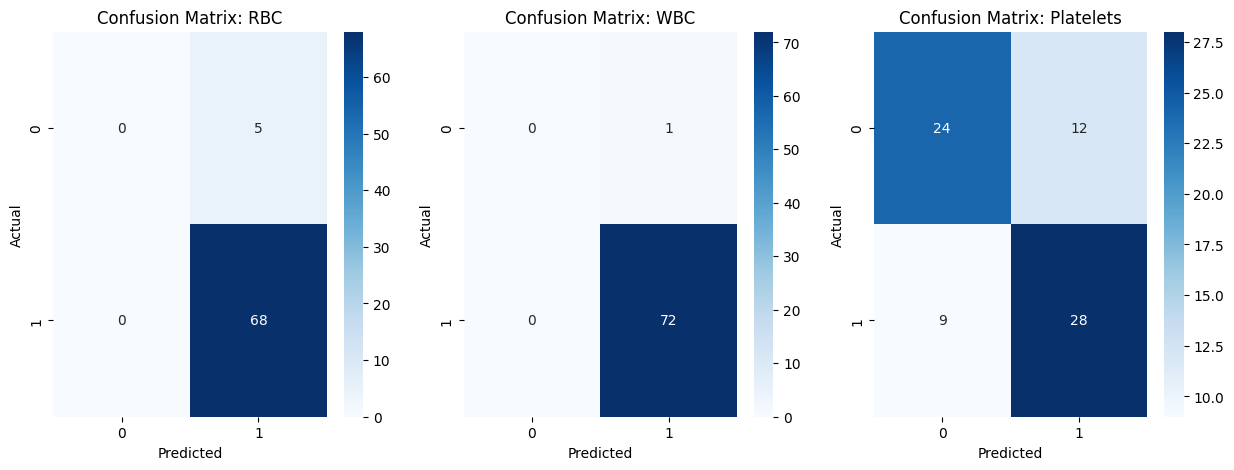

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute confusion matrices (one per class)
conf_matrices = multilabel_confusion_matrix(all_labels, all_preds)

# Define class names
class_names = ["RBC", "WBC", "Platelets"]

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    sns.heatmap(conf_matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix: {class_names[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.show()

Show sample images with predictions

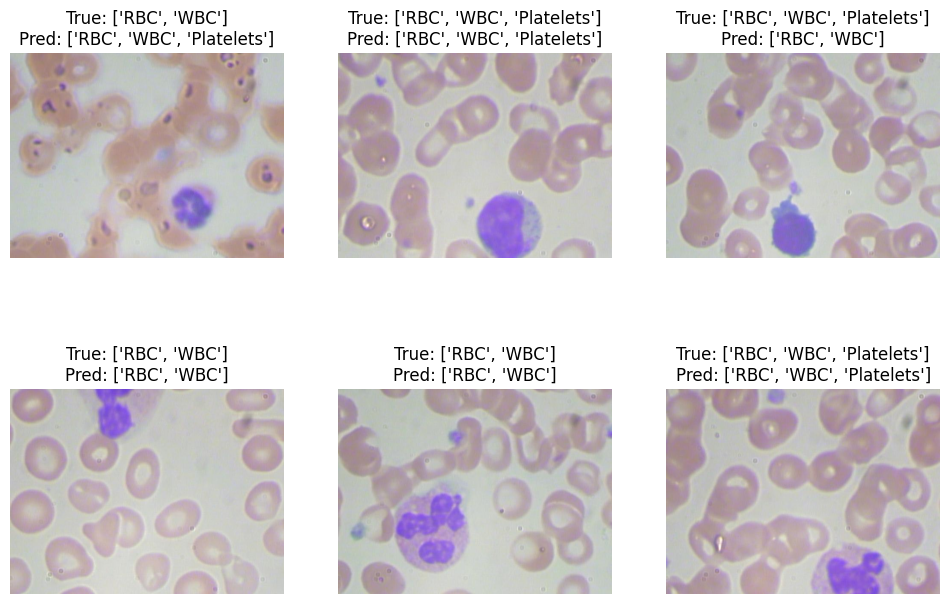

In [16]:
import random

# Pick random sample images
sample_indices = random.sample(range(len(test_df)), 6)
sample_images = [test_df.index[i] for i in sample_indices]

# Plot the images with predictions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    image_path = f"BCCD/JPEGImages/{sample_images[i]}"
    image = Image.open(image_path)
    
    # Get predictions for this image
    true_label = test_df.loc[sample_images[i]].values.astype(int)
    pred_label = all_preds[sample_indices[i]]
    
    # Convert to human-readable format
    true_classes = [class_names[j] for j in range(3) if true_label[j] == 1]
    pred_classes = [class_names[j] for j in range(3) if pred_label[j] == 1]
    
    ax.imshow(image)
    ax.set_title(f"True: {true_classes}\nPred: {pred_classes}")
    ax.axis("off")

plt.show()